# Conic Formulation of Unbalanced GW

Implement the bi-linear programming formulation of unbalanced Gromov-Wasserstein.

_Warning:_ you need to install `progressbar2` apparently with `pip install progressbar2`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import progressbar as pb

In [2]:
def distmat(x,y):
    return np.sqrt( np.abs(np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y) ) )

def normalize(a):
    return a/np.sum(a)

# Conic Unbalanced Gromov-Wasserstein (CGW)

## Generate data on ground space and conic coordinates

In [3]:
# un-even size for debugging
n = 6
m = 5
k = 10 # angle samples
l = 11 

# even size for production
n = 6
m = n
# angle samples
k = 10 
l = k 

Generate two measures in $\mathbb{R}^d$ to test the code.

In [4]:
# random histograms
a = normalize(np.random.exponential(scale=1.0, size=n))
b = normalize(np.random.exponential(scale=1.0, size=m))
d = 2 # dimension
x = np.random.rand(d,n)
y = np.random.rand(d,m)

Compute pairwise distance matrices $D_X(x,x') = \|x-x'\|_2$.

In [5]:
DX = distmat(x,x)
DY = distmat(y,y)

Discretized radius on the cones. *TODO:* select a larger radius since after the tested mass varies.

In [6]:
rmax = np.sqrt(np.max(np.concatenate((a,b))))
R = np.linspace(0,rmax,k)
S = np.linspace(0,rmax,l)

## Computation of the conic kernel

Compute the GW kernel (note that it is a 8D tensor).
$$
    K(x,r,x',r',y,s,y',s') 
    \triangleq \tau \Big[ (rr')^2 + (ss')^2 - 2 r's' e^{ - \frac{|D_X(x,x')-D_Y(y,y')|^2}{2\tau} } \Big]
$$

In [7]:
def GH(x,r,y,s,tau=1): return tau * ( r**2+s**2 - 2*r*s*np.exp( -np.abs(x-y)**2/(2*tau) ) )

# form the 8D kernel (x,r,x',r' ; y,s, y',s')
def CGW_Kernel(DX,DY,R,S,tau=1):
    return GH( DX[:,None,:,None, None,None,None,None], \
        R[None,:,None,None, None,None,None,None]*R[None,None,None,:, None,None,None,None], \
        DY[None,None,None,None, :,None,:,None], \
        S[None,None,None,None, None,:,None,None]*S[None,None,None,None, None,None,None,:], \
        tau)

# operator to apply K to a matching alpha, i.e. compute K*alpha
def apply_K(K,alpha):
    return np.sum( K * alpha[None,None,:,:, None,None,:,:], (2,3,6,7), keepdims=True ).squeeze()

Generate a conic kernel with $\tau=1$

In [8]:
tau = 1
K = CGW_Kernel(DX,DY,R,S, tau)
Alpha = np.random.exponential(scale=1.0, size=(n,k,m,l))
print(f'Dimension of conic kernel = {apply_K(K,Alpha).shape}')

Dimension of conic kernel = (6, 10, 6, 10)


Solve the conic GW problem, which is a bilinear non-convex problem, by alernating minimization
$$
    \min_{\alpha \geq 0} \{
        \langle K \alpha, \alpha \rangle
        :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j.         
        \}
$$

We first implement its linearized version, which is a conic unbalanced OT problem (CUW) associated to a 4-D cost tensor 
$$
    \min_{\alpha \geq 0} \{
        \langle C, \alpha \rangle
        :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j.         
        \}
$$

In [9]:
def Solve_CUW(C, R, S, n,k,m,l):
    # CVXPY problem setup 
    RR = np.tile(R, (n,1))
    SS = np.tile(S, (m,1))
    # variable
    alpha = cp.Variable((n*k,m*l))
    alpha1 = cp.Variable((n,k))
    alpha2 = cp.Variable((m,l))
    # constraints
    U = [0 <= alpha, 
            alpha1==cp.reshape(cp.sum(alpha, axis=1),(k,n)).T, \
            alpha2==cp.reshape(cp.sum(alpha, axis=0),(l,m)).T, \
            cp.sum( cp.multiply(alpha1, RR**2), 1)==a, \
            cp.sum( cp.multiply(alpha2, SS**2), 1)==b \
        ]
    
    C = C.reshape(n*k,m*l)
    objective = cp.Minimize( cp.sum(cp.multiply(alpha,C)) )
    prob = cp.Problem(objective, U)
    result = prob.solve(verbose=False)
    return alpha.value.reshape(n,k,m,l)

We define the CGW solver which solves the problem by performing alternate descent and solves a sequence of CUW problems.

In [10]:
# alternate minimization
def Solve_CGW(K, R, S, n,k,m,l, init, niter=10,verbose=True):
    CGWcost = np.zeros(niter)
    # initialize matching
    Alpha = init
    H = range(niter)
    if verbose:
        H = pb.progressbar(H)
    for it in H:
        Alpha = Solve_CUW( apply_K(K,Alpha), R, S, n,k,m,l )
        CGWcost[it] = np.sum( apply_K(K,Alpha).flatten() * Alpha.flatten() )
    return ( np.min(CGWcost.flatten()), CGWcost )

We now solve the blinear problem by alternating minimization. 

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


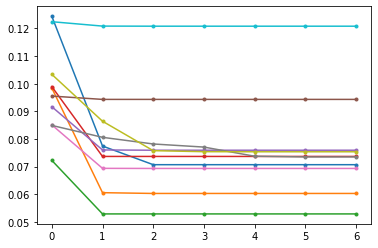

In [11]:
nruns = 10 # different initializations
niter = 7

CGWcost = np.zeros((niter,nruns))
for kt in range(nruns):
    init = np.random.exponential(scale=1.0, size=(n,k,m,l))
    init = init / np.sum(init.flatten())
    _, CGWcost[:, kt] = Solve_CGW(K, R, S, n,k,m,l, init, niter,nruns)
plt.plot(CGWcost, '.-');

TODO: find a way to convert a conic measure $\alpha$ into a classical GW matching $\pi$.

In [12]:
def dilation(x,r,y,s): return np.sqrt( r*s*np.exp( -abs(x-y)**2/(2*tau) ) )
# eta = dilation( R[None,:,None,None], S[None,None,None,:], D[:,None,:,None] )
# multiply by eta^2 and then marginalize on (x,y)
# pi = np.sum( np.sum( Alpha * eta**2, 1, keepdims=True), 3, keepdims=True).squeeze()
# plt.imshow(pi)

# Compare with Unbalanced Gromov Wasserstein (UGW)
We now consider the penalized fromulation
$$
    \min_{\pi \geq 0} \langle Q \pi, \pi \rangle 
    + \tau \text{KL}^{\otimes 2}(\pi_1|a)
    + \tau \text{KL}^{\otimes 2}(\pi_2|b)
$$
where the coupling is now $\pi \in \mathbb{R}_+^{n \times m}$ and the quadratic form is 
$$
    Q((x,y),(x',y')) \triangleq | D_X(x,x') - D_Y(y,y') |^2
$$
where the quadratic 

In [13]:
import sys
sys.path.append("../")
import torch
# from solver.vanilla_sinkhorn_solver import VanillaSinkhornSolver
from solver.batch_stable_sinkhorn_solver import BatchStableSinkhornSolver
from solver.utils import generate_measure
torch.set_printoptions(8)
import itertools

We initialize the UGW solver. We consider a low level of entropy to approximate the unregularized problem.

In [14]:
epsilon, tau = 0.01, 1.
# solv = VanillaSinkhornSolver(nits_plan=1, nits_sinkhorn=300, gradient=False, tol_plan=1e-5, tol_sinkhorn=1e-5,
#                              eps=epsilon, rho=float(tau))
solv = BatchStableSinkhornSolver(nits_plan=100, nits_sinkhorn=1000, gradient=False, tol_plan=1e-5, tol_sinkhorn=1e-5,
                             eps=epsilon, rho=float(tau))

We define the solver which casts the numpy data to solve the UGW problem with pytorch.

In [15]:
def Solve_UGW(DX,DY,a,b,init,verbose=True):
    DX1 = torch.from_numpy(DX).type(torch.FloatTensor)
    DY1 = torch.from_numpy(DY).type(torch.FloatTensor)
    a1 = torch.from_numpy(a).type(torch.FloatTensor)
    b1 = torch.from_numpy(b).type(torch.FloatTensor)
    H = range(nruns)
    if verbose:
        H = pb.progressbar(H)
    
    pi0 = init
    # For stable solver
    pi = solv.ugw_sinkhorn(a1[None,:], DX1[None,:,:], b1[None,:], DY1[None,:,:], init=pi0[None,:,:])
    cost = solv.ugw_cost(pi, pi, a1[None,:], DX1[None,:,:], b1[None,:], DY1[None,:,:])
#     print(cost)
#     cost = cost - eps * solv.quad_kl_div(pi, pi, a1[None,:, None] * b1[None, None, :])
    return cost.item()

In [16]:
law = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
UGWcost = np.zeros(nruns)
for kt in range(nruns):
    pi0 = law.sample((n,m)).reshape((n,m))
    pi0 = pi0/torch.sum(pi0)
    UGWcost[kt] = Solve_UGW(DX,DY,a,b,pi0,verbose=True)
print( str('UCG = ') + str(np.sort( UGWcost )) )
print( str('CCG = ') + str(np.sort( CGWcost[-1,:] )) )

UCG = [0.07493518 0.07493528 0.07493535 0.08527409 0.08993568 0.08993586
 0.08993592 0.08993592 0.089936   0.09419368]
CCG = [0.05284803 0.06025791 0.06930991 0.07067179 0.07347466 0.07366036
 0.07534822 0.07590947 0.09431292 0.12081551]


# Randomized tests

*TODO:* impose a maximum value for the histograms in order to avoid going above the max radius of the cones.

In [17]:
ntests = 20
CGWcost = np.zeros(ntests)
UGWcost = np.zeros(ntests)
for kt in pb.progressbar(range(ntests)):
    # generate random points
    a = normalize(np.random.exponential(scale=1.0, size=n))
    b = normalize(np.random.exponential(scale=1.0, size=m))
    x = np.random.rand(d,n)
    y = np.random.rand(d,m)
    # associated kernel
    DX = distmat(x,x)
    DY = distmat(y,y)
    rmax = np.sqrt(np.max(np.concatenate((a,b))))
    R = np.linspace(0,rmax,k)
    S = np.linspace(0,rmax,l)
    K = CGW_Kernel(DX,DY,R,S)
    
    # run CGW and UGW over grid of init
    cgw, ugw = np.zeros(nruns), np.zeros(nruns)
    for it in range(nruns):
        init = np.random.exponential(scale=1.0, size=(n,k,m,l))
        init = init / np.sum(init.flatten())
        cgw[it], _ = Solve_CGW(K,R, S, n,k,m,l, init, niter, verbose=False)
        
        law = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
        pi0 = law.sample((n,m)).reshape((n,m))
        pi0 = pi0/torch.sum(pi0)
        ugw[it] = Solve_UGW(DX,DY,a,b, pi0,verbose=False)
        
    CGWcost[kt], UGWcost[kt] = np.min(cgw), np.min(ugw)

100% (20 of 20) |########################| Elapsed Time: 0:02:58 Time:  0:02:58


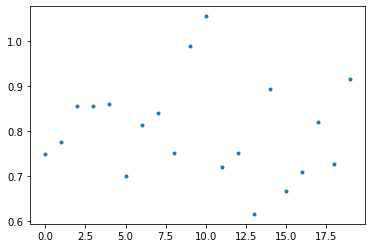

In [18]:
plt.plot( CGWcost / UGWcost, '.');

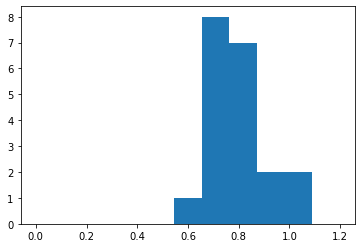

In [19]:
plt.hist( CGWcost / UGWcost, np.linspace(0,1.2,12) );

# Sanity checks

## Control for distinguishing pairs of diracs

In [20]:
#Values
n = 1
m = 1
k = 10 # angle samples
l = 11 

# generate random points and metrics
a = (np.random.exponential(scale=1.0, size=n))
b = (np.random.exponential(scale=1.0, size=m))
x = np.random.rand(d,n)
y = np.random.rand(d,m)
DX = distmat(x,x)
DY = distmat(y,y)

# conic kernel
rmax = np.sqrt(np.max(np.concatenate((a,b))))
R = np.linspace(0,rmax,k)
S = np.linspace(0,rmax,l)
K = CGW_Kernel(DX,DY,R,S)

# run CGW

cgw, ugw = np.zeros(nruns), np.zeros(nruns)
for it in range(nruns):
    init = np.random.exponential(scale=1.0, size=(n,k,m,l))
    init = init / np.sum(init.flatten())
    cgw[it], _ = Solve_CGW(K,R, S, n,k,m,l, init, niter, verbose=False)

    law = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
    pi0 = law.sample((n,m)).reshape((n,m))
    pi0 = pi0/torch.sum(pi0)
    ugw[it] = Solve_UGW(DX,DY,a,b, pi0,verbose=False)

print(f"Theoretical value = {(a-b)**2} / CGWcost = {np.min(cgw)} / UGWcost = {np.min(ugw)}")

Theoretical value = [29.37617621] / CGWcost = 29.38618986766865 / UGWcost = 29.447235107421875


## Observation for two pairs of dirac

In [21]:
#Values
n = 2
m = 2
k = 10 # angle samples
l = 11 

# generate random points and metrics
d = 2
a = (np.random.exponential(scale=1.0, size=n))
b = (np.random.exponential(scale=1.0, size=m))
x = np.random.rand(d,n)
y = np.random.rand(d,m)
DX = distmat(x,x)
DY = distmat(y,y)

# conic kernel
rmax = np.sqrt(np.max(np.concatenate((a,b))))
R = np.linspace(0,rmax,k)
S = np.linspace(0,rmax,l)
K = CGW_Kernel(DX,DY,R,S)

# Number of random runs
niter = 7
nruns = 10

# run CGW
cgw, ugw = np.zeros(nruns), np.zeros(nruns)
for it in range(nruns):
    init = np.random.exponential(scale=1.0, size=(n,k,m,l))
    init = init / np.sum(init.flatten())
    cgw[it], _ = Solve_CGW(K,R, S, n,k,m,l, init, niter, verbose=False)

    law = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
    pi0 = law.sample((n,m)).reshape((n,m))
    pi0 = pi0/torch.sum(pi0)
    ugw[it] = Solve_UGW(DX,DY,a,b, pi0,verbose=False)
print(f" CGWcost = {np.min(cgw)} / UGWcost = {np.min(ugw)}")

 CGWcost = 7.180201113199675 / UGWcost = 7.257515907287598


# Evolution of the comparison btw CGW/UGW when two mm-spaces gets further
We take a set of samples $x$ and a measure $a$. We consider a perturbation $\delta$ and compare $x$ with $x + \epsilon\delta$ while increasing progressively $\epsilon$.

n,k,m,l =  (4, 10, 4, 10)


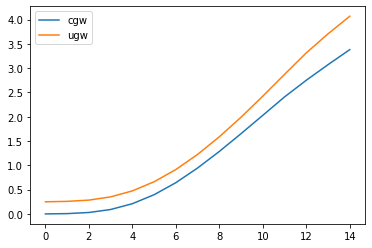

In [22]:
#Values
n = 4
m = n
k = 10 # angle samples
l = k
print("n,k,m,l = ", (n,k,m,l))

# generate random points and metrics
d = 2
a = (np.random.exponential(scale=1.0, size=n))
b = a
x = np.random.rand(d,n)
delta = np.random.normal(size=(d,n))

# Number of random runs
niter = 7
nruns = 20
nsteps = 15
eps = np.linspace(0,1,num=nsteps)
val_cgw, val_ugw = np.zeros(nsteps), np.zeros(nsteps)

for i in range(nsteps):
    DX = distmat(x,x)
    DY = distmat(x + eps[i] * delta, x + eps[i] * delta)

    # conic kernel
    rmax = np.sqrt(np.max(np.concatenate((a,b))))
    R = np.linspace(0,rmax,k)
    S = np.linspace(0,rmax,l)
    K = CGW_Kernel(DX,DY,R,S)

    # run CGW
    cgw, ugw = np.zeros(2 * nruns + 1), np.zeros(2 * nruns + 1)
    for it in range(nruns):
        init = np.random.exponential(scale=1.0, size=(n,k,m,l))
        init = init / np.sum(init.flatten())
        cgw[it], _ = Solve_CGW(K,R, S, n,k,m,l, init, niter, verbose=False)

        law = torch.distributions.exponential.Exponential(torch.tensor([1.0]))
        pi0 = law.sample((n,m)).reshape((n,m))
        pi0 = pi0/torch.sum(pi0)
        ugw[it] = Solve_UGW(DX,DY,a,b, pi0,verbose=False)
        
    for it in range(nruns):
        init = np.eye(n)[np.random.permutation(n),:]
        pi0 = torch.from_numpy(init).float()
        init = np.tile(init[:,None,:,None], (1,k,1,l))
        cgw[nruns + it], _ = Solve_CGW(K,R, S, n,k,m,l, init, niter, verbose=False)
        
        ugw[nruns + it] = Solve_UGW(DX,DY,a,b, pi0,verbose=False)
        
    init = np.eye(n)
    pi0 = torch.from_numpy(init).float()
    init = np.tile(init[:,None,:,None], (1,k,1,l))
    cgw[-1], _ = Solve_CGW(K,R, S, n,k,m,l, init, niter, verbose=False)

    ugw[-1] = Solve_UGW(DX,DY,a,b, pi0,verbose=False)
        
    val_cgw[i] = np.min(cgw)
    val_ugw[i] = np.min(ugw)

# Plot results
plt.plot(eps, val_cgw, label='cgw')
plt.plot(eps, val_ugw, label='ugw')
plt.legend()
plt.show()

We debias UGW which is strictly positive due to the adjunction of entropy. We remove the entropic regularization term.

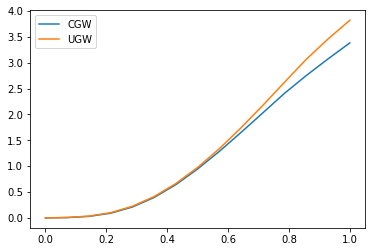

In [26]:
# Plot results
plt.plot(eps, val_cgw, label='CGW')
plt.plot(eps, val_ugw - val_ugw[0], label='UGW')
plt.legend()
plt.show()